In [1]:
import numpy as np

# Astropy
from astropy.io import fits, ascii
from astropy.wcs import WCS
from astropy.nddata.utils import Cutout2D
from astropy import units as u
from astropy.coordinates import SkyCoord

# Matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# Regions package
from regions import EllipseSkyRegion

# Setting matplotlib fonts
from matplotlib import rc
rc('text', usetex=True)
font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : '14'}
rc('font', **font)

In [2]:
%matplotlib notebook

this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]


<IPython.core.display.Javascript object>


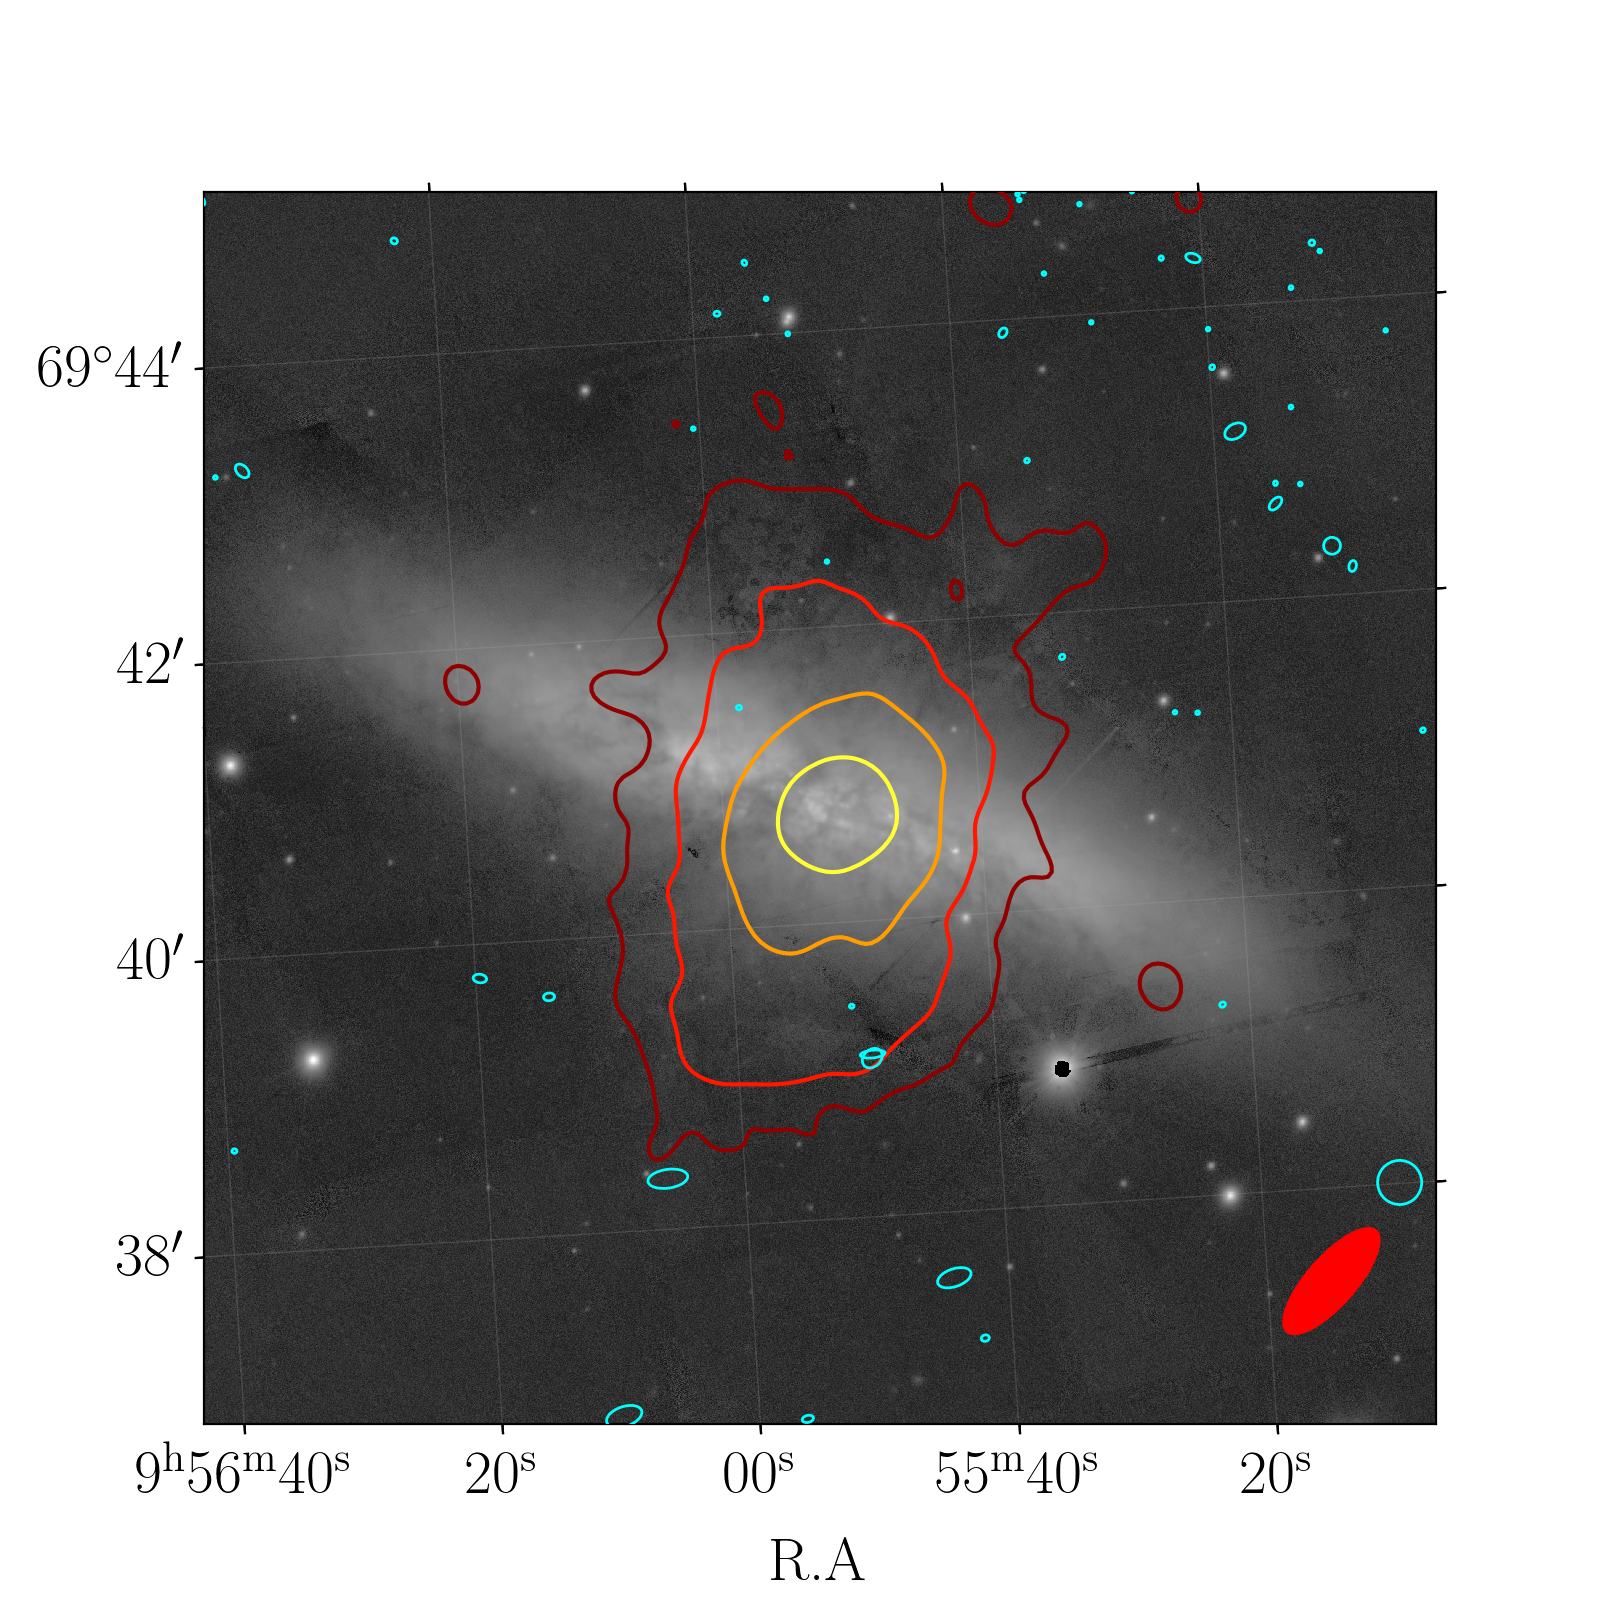

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [3]:
# Coordinates of the center of the image (RA and Dec)
# In this case, we're making an image of M82, using coordinates from SIMBAD
center = SkyCoord(148.968458*u.degree, 69.679703*u.degree, frame='icrs')

# The background image (Here a g-band image of M82 from Pan-STARR):
bkg_fname = 'm82_gband.fits'
bkg_im  =  fits.open(bkg_fname)
bkg_data = bkg_im[1].data
bkg_wcs = WCS(bkg_im[1].header, naxis=2)
bkg_cut = Cutout2D(bkg_data,center, [2000,2000], wcs=bkg_wcs)

# Starting the figure and setting projection based on image WCS:
figure = plt.figure(figsize=(8,8))
ax = figure.add_subplot(1,1,1, projection=bkg_cut.wcs)

# Setting colormap details
cmap = plt.cm.gray
cmap.set_bad('black')
#cmap_norm = colors.LogNorm(vmin=0.01, vmax=20)
"""
The default normalization works well here.
But if needed, one can use various normalizations 
available. Some options available under matplotlib.colors: 
https://matplotlib.org/3.1.1/api/colors_api.html
"""

ax.imshow(bkg_cut.data,
          cmap = cmap,
          #norm = cmap_norm,
          aspect = 'equal',
          origin = 'lower', 
          interpolation = 'none',
          rasterized = True)

# IF you just want contours based on the same image as the background, it is simple:
#ax.contour(bkg_cut.data, **kwrds)

# But if you want to use another image with different WCS configuration/resolution/etc., it needs transformation:
# Here we use an X-ray image of M82 from Swift/XRT - With a different resolution, size, WCS style, etc.
contour_fname = 'm82_xrays.fits'
contour_im = fits.open(contour_fname)
contour_data = contour_im[0].data
contour_wcs = WCS(contour_im[0].header, naxis=2)

# Contour levels and colors should be set based on the data used for contours
contour_levels = [0.4,1,3,15]
contour_colors = plt.cm.hot([0.2,0.4,0.6,0.8])

ax.contour(contour_data,
           levels=contour_levels,
           colors=contour_colors,
           transform=ax.get_transform(contour_wcs))

"""
Bonus: Plotting regions 
For this, we use the package regions (not pyregions):
https://astropy-regions.readthedocs.io/en/latest/
"""

# Part 1: reading a catalog and plotting regions from that catalog
# Here we use X-ray point sources from Chandra X-ray catalog:
x_ray_sources = ascii.read('./chandra_sources.tsv')
for src in x_ray_sources:
    src_reg = EllipseSkyRegion(SkyCoord(src['ra'],src['dec'],unit=(u.hourangle,u.deg), frame='icrs'),
                               5*src['err_ellipse_r0']*u.arcsec,
                               5*src['err_ellipse_r1']*u.arcsec,
                               angle=src['err_ellipse_ang']*u.deg)
    src_pix_reg = src_reg.to_pixel(bkg_wcs)
    src_pix_reg.visual['color'] = 'cyan'
    src_pix_reg.visual['linewidth'] = 1.0
    src_pix_reg.plot(ax=ax,zorder=10)

# Part 2: Adding a representation of resolution, PSF, beam, etc.
# Here, we plot a random ellipse as an example of some beam shape
beam = EllipseSkyRegion(SkyCoord(148.9*u.degree, 69.55*u.degree, frame='icrs'),55*u.arcsec,20*u.arcsec,angle=45*u.deg)
beam_pix_reg = beam.to_pixel(bkg_wcs)
beam_pix_reg.visual['fill'] = 1
beam_pix_reg.visual['color'] = 'red'
beam_pix_reg.visual['linewidth'] = 0.5
beam_pix_reg.plot(ax=ax,facecolor='red',zorder=10)

# Cosmetics
ax.grid(linewidth=0.5,alpha=0.2)
ax.set_xlabel(r"R.A", size=22)
ax.set_ylabel(r"Dec", size=22)
ax.tick_params(labelsize=22)
# Save it:
#plt.savefig('image.pdf',bbox_inches='tight')

## Comparison with a high-resolution Chandra/HST/Spitzer image

![](https://upload.wikimedia.org/wikipedia/commons/thumb/8/83/M82_Chandra_HST_Spitzer.jpg/739px-M82_Chandra_HST_Spitzer.jpg)